We are going to create a simple image detection algorithm for cat images. This code is liberally taken from [Logistic Regression with a Neural Network mindset](https://github.com/andersy005/deep-learning-specialization-coursera/blob/master/01-Neural-Networks-and-Deep-Learning/week2/Programming-Assignments/Logistic%2BRegression%2Bwith%2Ba%2BNeural%2BNetwork%2Bmindset%2Bv3.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset # <-- this is from the Github project mentioned above

# Loading Test/Training Images
Test images are from `datasets/test_catvnoncat.h5` and training images are from `datasets/train_catvnoncat.h5`. The function `load_dataset` handles the loading details.

In [2]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Here is one of the images from the training set

y = [1], it's a 'cat' picture.


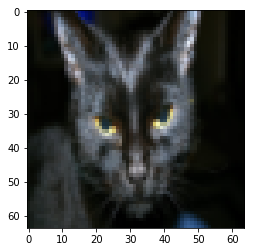

In [3]:
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [4]:
["Number of training examples: {}".format(train_set_x_orig.shape[0]),
"Number of testing examples: {}".format(test_set_x_orig.shape[0]),
"Height/Width of each image: {}".format(test_set_x_orig.shape[1])]

['Number of training examples: 209',
 'Number of testing examples: 50',
 'Height/Width of each image: 64']

So, we have 209 images in our training set, but only 50 examples in our testing one. That reads a bit strange. Intuitively, I would expect to train on the smaller set of examples, and then test the performance on the larger set. Oh, and each image is just a 64x64 pixel color image.

First, we will reshape the images so that they are represented as a 1 column vector of bytes, with the RGB color information being interleaved in the result. For instance, the first three numbers of the vector will be the red, blue and green components of the first pixel in a cat image. The reason for doing this is not spelled out up front, but it has to do with how we will process the 1 column vectors below in our algorithms. Putting it in 1 (long) column form now makes things much easier to calculate with in the near future.

Intuitively, separating out the color bytes does not seem too beneficial. A better approach might be to convert to gray scale so that we only operate on one color value between black and white, and not three separate ones.

In [5]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

Next, rescale each of the color component values so that they fall between 0 and 1. Since each color component value is a 8-bit value between 0 and 255, we just divide them all by 255.0 to get the desired range. Again, I'm curious what the outcome would be if we instead work with one color value instead of three.

In [6]:
train_set_x = train_set_x_flatten / 255.0
test_set_x = test_set_x_flatten / 255.0

# Build Neural Network of One Node
The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

In [7]:
def initialize_with_zeros(dim):
    return  np.zeros([dim, 1]), 0.0

### Forward and Backward propagation

Execute the "forward" and "backward" propagation steps for learning the parameters.

- Given $X$
- Compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

The "backward" bit is when we evaluate how well the estimate fits the truth value given as $Y$. Evaluating this fitness is done below using _gradient descent_ which is a fancy name for a search for the global minima of a _convex function_, which is basically a function that meets various criteria that guarantee there is only one global minima. Here are the partial differential equations for $d$ and $w$ which define the gradiant that will move along the cost function as we attempt to locate the minima.

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

The $\sigma$ function is the _sigmoid_ function, which maps a real input $Z$ to the range (0, 1). Both ends are open since 0 and 1 are never actually reached, but it is a nice and simple way to map values to a binary 0/1 domain. Note that there must be some reason for doing the mapping -- just blindly applying $\sigma$ will probably not lead to very good results.

In [8]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

The propagate function holds the cost function and generates the gradient value updates for a given iteration of the learning.

In [9]:
def propagate(w, b, X, Y):
    m = X.shape[1]
    A = sigmoid(np.dot(w.T, X) + b)
    cost = - np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A)) / m
    diffAY = A - Y
    dw = np.dot(X, diffAY.T) / m
    db = np.sum(diffAY) / m
    return dw, db, cost

## Optimization
We will repeatedly evaluate a cost function, which by careful selection is a convex function -- one that always has a global minimum. It is this global minimum which we will seek to reach, by updating `w` and `b` values with their derivatives and a `learning rate` parameter. Currently, the latter is fixed, but one could easily see a use in having it not so that converging toward the minima does not overshoot and begin oscillating back and forth over it. Below we also record the `cost` scalar in each iteration so we can see how they converge later on.

In [10]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = [None] * num_iterations
    for i in range(num_iterations):
        dw, db, cost = propagate(w, b, X, Y)
        w = w - learning_rate * dw
        b = b - learning_rate * db
        costs[i] = cost
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    return w, b, costs

## Prediction
Calculate estimate $\hat{Y} = A = \sigma(w^T X + b)$
Convert the entries of A into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. Here we use the nifty Numpy `where` operator which lets us map a comparison on a set of values instead of looping over them in Python.

In [11]:
def predict(w, b, X):
    return np.where(sigmoid(np.dot(w.T, X) + b) > 0.5, 1.0, 0.0)

## Build Model
Implement the model function:
- Y_prediction_test are the predictions on the test set
- Y_prediction_train are the predictions on the train set
- w, b, costs are the outputs of optimize()

In [12]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    w, b = initialize_with_zeros(X_train.shape[0])
    w, b, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    print("train accuracy: {}%".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {}%".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    return Y_prediction_test, costs

Run the following cell to train your model.

In [13]:
Y_prediction_test, costs = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694%
test accuracy: 70.0%


In [14]:
Y_prediction_test

array([[1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
        0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        1., 0.]])

# Results
Let's evaluate how well our predicitions matched those of the test data. First, go through and determine what were false positives (FP) -- predictions of a cat where the test data said there probably was not a cat (< 50% chance) -- and what were false negatives -- predictions where we said there was no cat, but test data said there was (> 50% chance).

In [15]:
FN = []
FP = []
for index in range(len(test_set_x[0])):
    test = test_set_x[0, index]
    pred = Y_prediction_test[0, index]
    if test > 0.50:
        if pred > 0.7:
            kind = "TP"
        else:
            kind = "FN **"
            FN.append(index)
    else:
        if pred > 0.8:
            kind = "FP **"
            FP.append(index)
        else:
            kind = "TN"
    print("{:0<5.2}, {}, {}".format(test, pred, kind))

0.620, 1.0, TP
0.450, 1.0, FP **
1.000, 1.0, TP
1.000, 1.0, TP
0.380, 1.0, FP **
0.100, 1.0, FP **
0.940, 0.0, FN **
0.930, 1.0, TP
0.075, 1.0, FP **
0.910, 1.0, TP
0.140, 0.0, TN
1.000, 0.0, FN **
0.067, 1.0, FP **
0.920, 1.0, TP
0.360, 0.0, TN
0.890, 1.0, TP
0.078, 0.0, TN
0.530, 1.0, TP
0.720, 0.0, FN **
0.640, 0.0, FN **
0.570, 1.0, TP
0.047, 0.0, TN
0.250, 0.0, TN
1.000, 1.0, TP
0.280, 1.0, FP **
0.820, 1.0, TP
0.970, 1.0, TP
0.170, 0.0, TN
0.470, 0.0, TN
0.910, 1.0, TP
0.047, 0.0, TN
0.250, 1.0, FP **
0.039, 1.0, FP **
0.720, 0.0, FN **
0.890, 1.0, TP
0.350, 0.0, TN
0.430, 0.0, TN
0.340, 1.0, FP **
0.730, 0.0, FN **
0.027, 0.0, TN
0.750, 1.0, TP
0.340, 0.0, TN
0.350, 1.0, FP **
0.082, 0.0, TN
0.110, 1.0, FP **
0.170, 0.0, TN
0.580, 0.0, FN **
0.160, 1.0, FP **
0.071, 1.0, FP **
0.520, 0.0, FN **


First, display the false positive images.

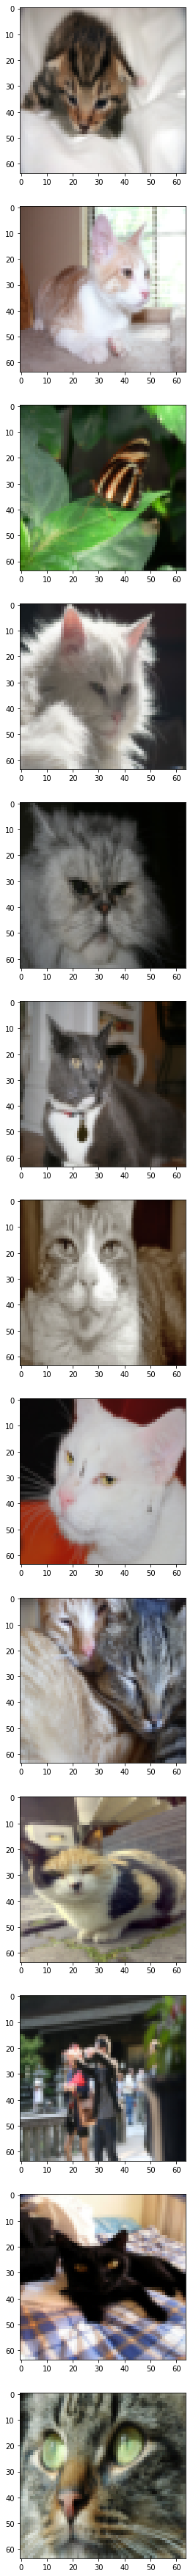

In [16]:
num_px = 64
fig = plt.figure(1, figsize = (num_px, num_px))
for pos, index in enumerate(FP):
    image = test_set_x[:, index].reshape((num_px, num_px, 3))
    ax = fig.add_subplot(len(FP), 1, pos + 1)
    ax.imshow(image)

Next, display the false negative images.

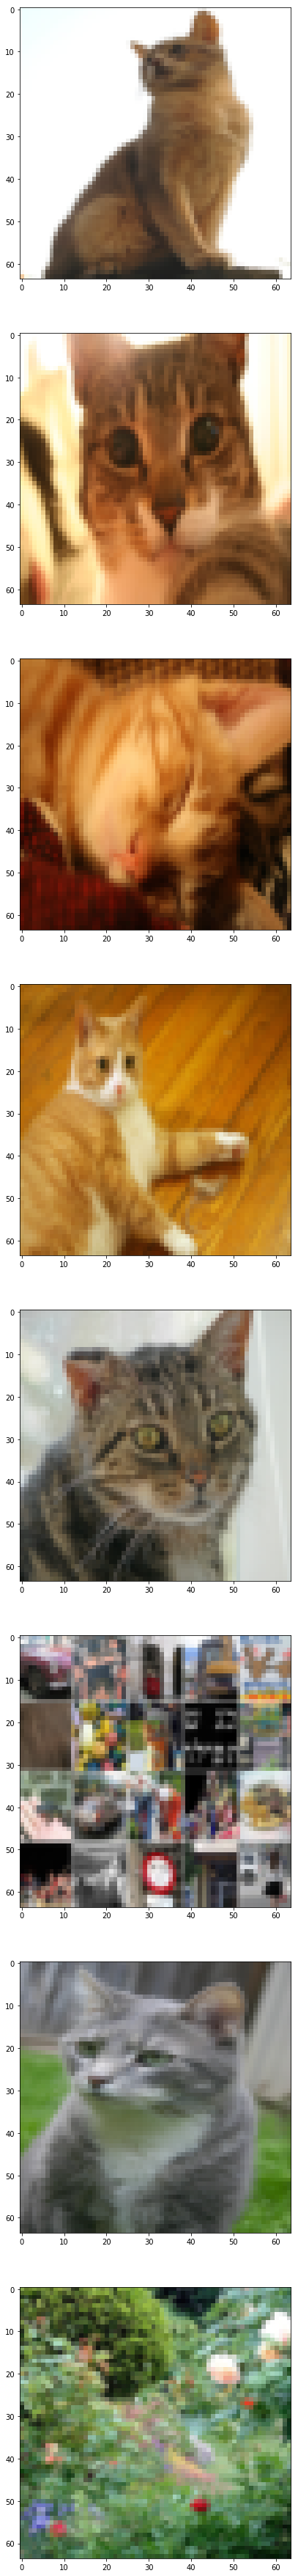

In [17]:
num_px = 64
fig = plt.figure(1, figsize = (num_px, num_px))
for pos, index in enumerate(FN):
    image = test_set_x[:, index].reshape((num_px, num_px, 3))
    ax = fig.add_subplot(len(FN), 1, pos + 1)
    ax.imshow(image)

# Cost Reduction
Here is a plot showing how the cost values fell as we iterated in the optimization step.

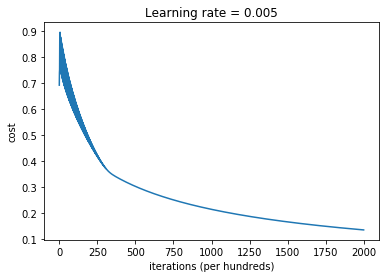

In [18]:
costs = np.squeeze(costs)
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate = 0.005")
plt.show()

# Additional Analysis
We can rerun the above for different iteration amounts and learning rate values $\alpha$.

learning rate: 0.01
train accuracy: 99.52153110047847%
test accuracy: 68.0%
learning rate: 0.001
train accuracy: 88.99521531100478%
test accuracy: 64.0%
learning rate: 0.0001
train accuracy: 68.42105263157895%
test accuracy: 36.0%


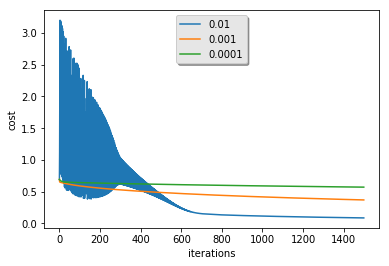

In [19]:
learning_rates = [0.01, 0.001, 0.0001]
models = []
for lr in learning_rates:
    print("learning rate: {}".format(lr))
    models.append(model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = lr, print_cost = False))

for lr, m in zip(learning_rates, models):
    plt.plot(m[1], label="{}".format(lr))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

So this is kind of silly, because the _learning rate_ is a scalar that is multiplied to the $w$ and $b$ derivatives while searching for the global minima. A smaller learning rate just means that we crawl more slowly towards that magical goal. We could be smarter and evaluate the changes in the derivatives across iterations with a given learning rate, and if they go from negative to positive or vice-versa, then we have crossed the global minima and we can refine our search as long as there are iterations left to use.

And this is just the behavior we see above in the $0.01$ learning rate cost curve. The wild oscillations are due to the extreme slopes of the cost function; as we get closer to the minima the oscillations quickly subside and we more or less arrive close to the minima value. With the lower learning rate values, we don't see the early oscillations, but we also don't ever arrive at the same minima because we run out of iterations before we can get there.

We can easily see this by making the iteration count proportional to the learning rate -- `num_iterations = int(15 / lr)` -- in the call to our `model` function above.

(NOTE: this will take some time to run due to the explosion in the iteration counts):

learning rate: 0.01
train accuracy: 99.52153110047847%
test accuracy: 68.0%
learning rate: 0.001
train accuracy: 99.52153110047847%
test accuracy: 68.0%


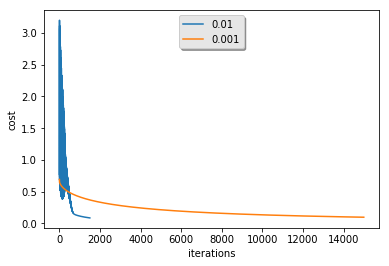

In [20]:
learning_rates = [0.01, 0.001]
models = []
for lr in learning_rates:
    print("learning rate: {}".format(lr))
    models.append(model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = int(15 / lr), learning_rate = lr, print_cost = False))

for lr, m in zip(learning_rates, models):
    plt.plot(m[1], label="{}".format(lr))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

Note that with the change in interation counts, we now arrive at the exact same cost minima for all of the learning rate values, but this effort is wasted for the smaller learning rates, as they essentially waste time to reach a point we already knew about with a larger learning rate.